<a href="https://colab.research.google.com/github/Swastik3025/Flower_Classification-using-VGG16-New/blob/main/Colab%20Notebook/Flower_classifier_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATASET LOADING


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

100% 241M/242M [00:06<00:00, 44.5MB/s]
100% 242M/242M [00:06<00:00, 38.7MB/s]


In [3]:
#Unzipping file
import zipfile
zip_ref=zipfile.ZipFile('/content/5-flower-types-classification-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

#IMPORTING LIBRARIES

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,Flatten,Dense,Activation,Dropout
import os
import pathlib
import cv2

#DATA LOADING

In [5]:
path='/content/flower_images'
os.listdir(path)

['Orchid', 'Lilly', 'Lotus', 'Sunflower', 'Tulip']

In [6]:
os.listdir(os.path.join(path,'Lilly'))

['7905bec55f.jpg',
 '6d77f956d3.jpg',
 '9cd4a405eb.jpg',
 '7dd0a0bc05.jpg',
 'c8f1c46a40.jpg',
 'ad0cdf9547.jpg',
 'af0cadb213.jpg',
 'e6ac9c9b5f.jpg',
 '0c1ec48a64.jpg',
 '65c455cb32.jpg',
 '4bd5ee0dd7.jpg',
 '82922fc82b.jpg',
 'c246fe7b07.jpg',
 '4b8e33ef6e.jpg',
 '7cfec87280.jpg',
 '7ac5bb68a2.jpg',
 '19b61d6fe0.jpg',
 '817f85db7f.jpg',
 '586085c837.jpg',
 'c35badb460.jpg',
 'd307c1d17e.jpg',
 '2824ba3315.jpg',
 '9971111b04.jpg',
 '17a173e95d.jpg',
 'a255e8a11a.jpg',
 'be2f191d96.jpg',
 'f57cadd09c.jpg',
 'ce78da827a.jpg',
 '60a9226675.jpg',
 '769a385b3e.jpg',
 '3fd23f812f.jpg',
 'df770df5f5.jpg',
 '6eb1825b00.jpg',
 '177cf77bf7.jpg',
 '224e9dc2fc.jpg',
 '60a779d75a.jpg',
 'e3fe994860.jpg',
 '0cd15008ae.jpg',
 '301b28fabe.jpg',
 '4c8c0ba072.jpg',
 'ced126775f.jpg',
 'd9c14787b5.jpg',
 '5924fc5e6e.jpg',
 '54b5f79ea2.jpg',
 'e97314c593.jpg',
 '782e41c92e.jpg',
 'f7b49da4df.jpg',
 'e8d7cc487e.jpg',
 'aa51f734bf.jpg',
 '7dc25a962d.jpg',
 '47895917ba.jpg',
 '8e690a61ca.jpg',
 '62b63643fc

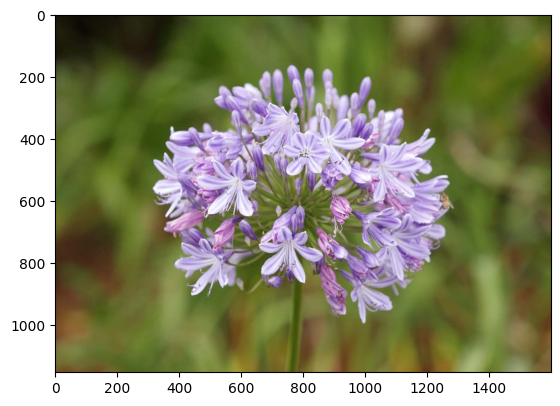

Image Size= (1152, 1600, 3)


In [7]:
random_img = cv2.imread("/content/flower_images/Lilly/883432a6cf.jpg")
plt.imshow(cv2.cvtColor(random_img,cv2.COLOR_BGR2RGB))
plt.show()
print("Image Size=",random_img.shape)

In [8]:
data=keras.utils.image_dataset_from_directory(path,batch_size=32,image_size=(256,256),shuffle=True)

Found 4999 files belonging to 5 classes.


In [9]:
data_iterator=data.as_numpy_iterator()
data_iterator

In [10]:
batch=data_iterator.next()

In [11]:
len(batch)  #there will be two parts to this dataser one is image and other one is label

2

In [12]:
batch[0].shape

(32, 256, 256, 3)

In [13]:
batch[1]

array([2, 2, 4, 4, 4, 2, 0, 0, 3, 3, 2, 2, 1, 0, 0, 3, 2, 2, 2, 3, 0, 1,
       0, 0, 2, 4, 3, 4, 2, 2, 3, 0], dtype=int32)

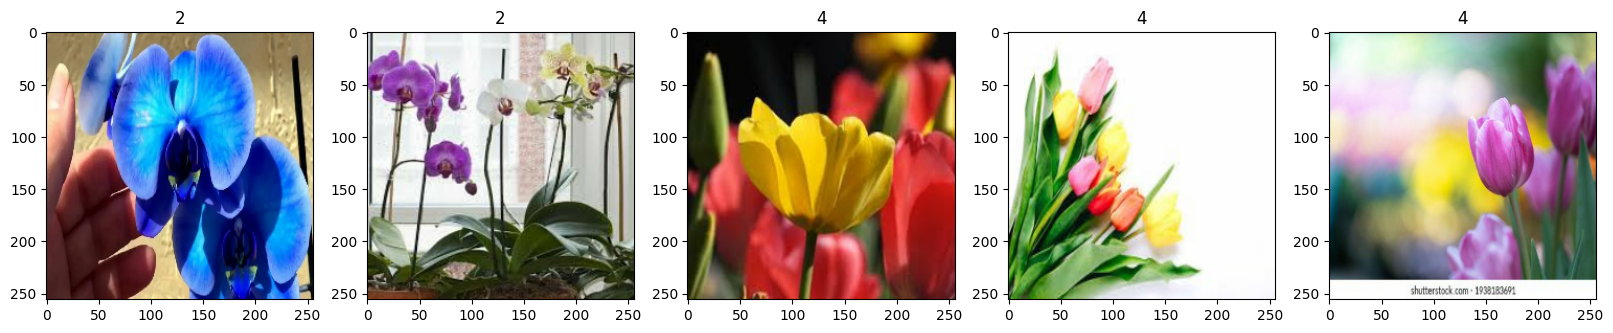

In [14]:
fig,ax=plt.subplots(ncols=5,figsize=(20,20))
for idx,img in enumerate(batch[0][:5]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

#0-lilly,1-Lotus,2-Orchid,3-Sunflower,4-Tulip

In [15]:
classes=['Lilly','Lotus','Orchid','Sunflower','Tulip']

#DATA SCALING

In [16]:
data=data.map(lambda x,y:(x/255,y)) #x-images,y-target variables
print("Data scaling completed!")

Data scaling completed!


In [17]:
scaled_iterator=data.as_numpy_iterator()

In [18]:
batch=scaled_iterator.next()

In [19]:
print("Range:",batch[0].min(),",",batch[0].max())

Range: 0.0 , 1.0


#TRAIN TEST VALIDATION SPLIT

In [20]:
print("Number of Batches =",len(data))

Number of Batches = 157


In [21]:
train_data=int(len(data)*0.7)
val_data=int(len(data)*0.2)+1
test_data=int(len(data)*0.1)+1
print("Data splitting completed!")

Data splitting completed!


In [22]:
print("Data splitting correct?:",train_data+val_data+test_data==157)

Data splitting correct?: True


In [23]:
train=data.take(train_data)
val=data.skip(train_data).take(val_data)
test=data.skip(train_data+val_data).take(test_data)

#VGG16 LOADING AND ARCHITECTURE BUILDING

In [24]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [25]:
base_model=VGG16(input_shape=(256, 256, 3),include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 3s 0us/step


In [26]:
for layer in base_model.layers:
    layer.trainable=False

In [27]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [28]:
custom_model = Sequential()

custom_model.add(base_model)
custom_model.add(global_average_layer)
custom_model.add(Dense(512, activation="relu"))
custom_model.add(Dropout(0.4))
#custom_model.add(Dense(20, activation="relu"))
#custom_model.add(Dropout(0.2))
custom_model.add(Dense(5, activation="softmax"))

custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
______________________________________

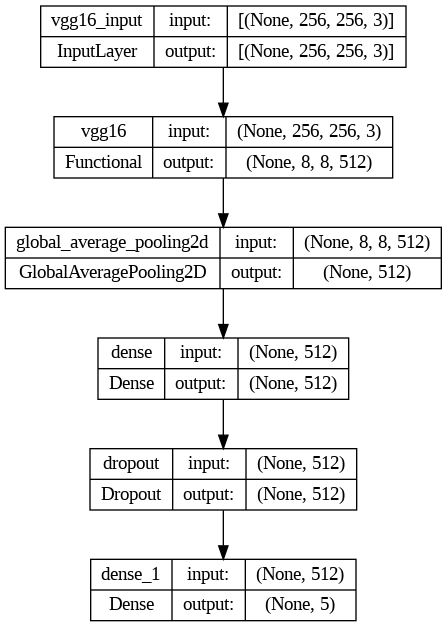

In [29]:
# Model Architecture visualisation
from keras.utils import plot_model
plot_model(custom_model,show_shapes=True,show_layer_names=True)

In [30]:
custom_model.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=["accuracy"]) #model compilation

In [31]:
logdir = "logs"
# directory where all the model training stages (checkpoints) will be added

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#TRAINING

In [32]:
history=custom_model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
109/109 [==============================] - 44s 282ms/step - loss: 1.1521 - accuracy: 0.5525 - val_loss: 0.8309 - val_accuracy: 0.7197
Epoch 2/20
109/109 [==============================] - 30s 269ms/step - loss: 0.7726 - accuracy: 0.7374 - val_loss: 0.7028 - val_accuracy: 0.7686
Epoch 3/20
109/109 [==============================] - 31s 278ms/step - loss: 0.6556 - accuracy: 0.7686 - val_loss: 0.6160 - val_accuracy: 0.7871
Epoch 4/20
109/109 [==============================] - 30s 273ms/step - loss: 0.5932 - accuracy: 0.7916 - val_loss: 0.6053 - val_accuracy: 0.7979
Epoch 5/20
109/109 [==============================] - 31s 285ms/step - loss: 0.5330 - accuracy: 0.8108 - val_loss: 0.5341 - val_accuracy: 0.8223
Epoch 6/20
109/109 [==============================] - 31s 280ms/step - loss: 0.5008 - accuracy: 0.8251 - val_loss: 0.5335 - val_accuracy: 0.8223
Epoch 7/20
109/109 [==============================] - 32s 285ms/step - loss: 0.4696 - accuracy: 0.8386 - val_loss: 0.5118 - val_ac

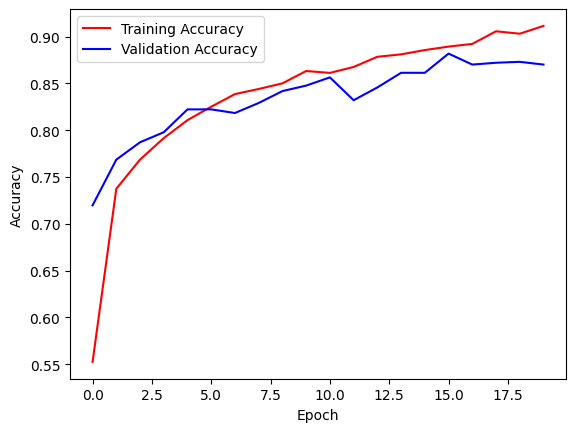

In [33]:
#Accuracy Graphs
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

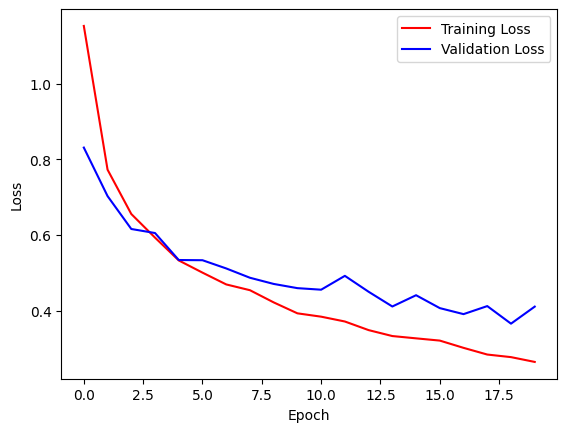

In [34]:
#loss graphs
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(loss))
plt.plot(epochs,loss,'r',label="Training Loss")
plt.plot(epochs,val_loss,'b',label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#MODEL EVALUATION

In [35]:
from tensorflow.keras.metrics import Precision,Recall,Accuracy

In [36]:
Pre=Precision()
Re=Recall()
Acc=Accuracy()

for batch in test.as_numpy_iterator():
  X,y=batch
  yhat=custom_model.predict(X)
  yhat=tf.math.argmax(yhat,axis=1)
  Pre.update_state(y,yhat)
  Re.update_state(y,yhat)
  Acc.update_state(y,yhat)

F1_score=(2*Pre.result()*Re.result())/(Pre.result()+Re.result())

print("Precision:",Pre.result())
print("Recall:",Re.result())
print("F1 Score:",F1_score)
print("Accuracy:",Acc.result())

1/1 [==============================] - 2s 2s/step
Precision: tf.Tensor(0.9293194, shape=(), dtype=float32)
Recall: tf.Tensor(0.93421054, shape=(), dtype=float32)
F1 Score: tf.Tensor(0.9317586, shape=(), dtype=float32)
Accuracy: tf.Tensor(0.8603696, shape=(), dtype=float32)


In [48]:
#saving the model
from keras.models import save_model
save_model(custom_model,'/content/drive/MyDrive/Flower_class_new.h5')

#TESTING ON NEW IMAGES

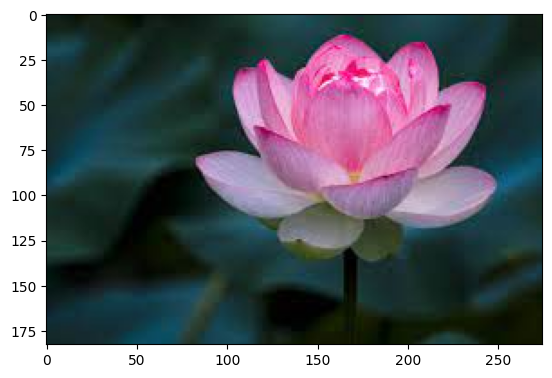

In [37]:
import cv2
test_img = cv2.imread("/content/lotus.jpg")
plt.imshow(cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB))
plt.show()

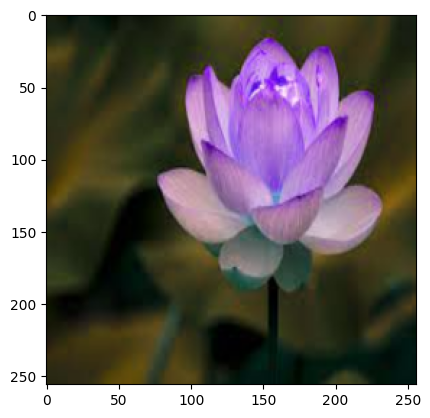

In [38]:
resize_test=tf.image.resize(test_img,(256,256))
plt.imshow(resize_test.numpy().astype(int))
plt.show()

In [39]:
resize_test.shape, np.expand_dims(resize_test/255.0, 0).shape

(TensorShape([256, 256, 3]), (1, 256, 256, 3))

In [40]:
yhat=tf.math.argmax(custom_model.predict(np.expand_dims(resize_test/255.0, 0)),axis=1)

1/1 [==============================] - 1s 522ms/step


In [41]:
yhat

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>

In [42]:
print("Predicted class is",classes[yhat[0]])

Predicted class is Lotus


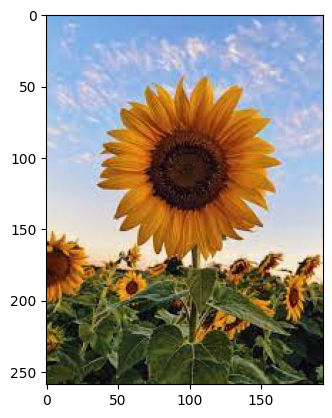

In [43]:
test_img_2=cv2.imread("/content/sunflower.jpg")
plt.imshow(cv2.cvtColor(test_img_2,cv2.COLOR_BGR2RGB))
plt.show()

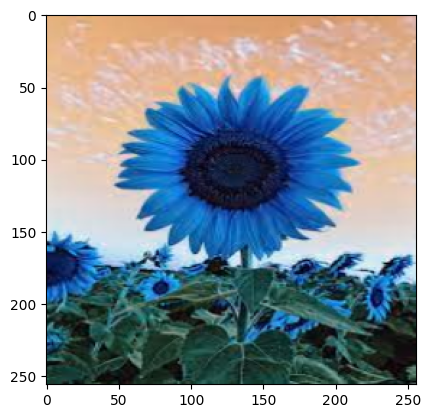

In [44]:
resize_test_2=tf.image.resize(test_img_2,(256,256))
plt.imshow(resize_test_2.numpy().astype(int))
plt.show()

In [45]:
resize_test_2.shape,np.expand_dims(resize_test_2/255.0, 0).shape

(TensorShape([256, 256, 3]), (1, 256, 256, 3))

In [46]:
yhat_2=tf.math.argmax(custom_model.predict(np.expand_dims(resize_test_2/255.0,0)),axis=1)

1/1 [==============================] - 0s 20ms/step


In [47]:
print("Predicted class is",classes[yhat_2[0]])

Predicted class is Sunflower
